# code2vec model
## Выглядит так: 
![code2vec](img/code2vec_network.jpg)


мы существуем в папке experimental, поэтому нужно вернуться в корень репозитория, чтобы иметь доступ к vocabulary.py и path_context_reader.py

In [1]:
%cd ../

Базовая инициализация необходимых для работы переменных. 

In [2]:
import tensorflow as tf
import tensorboard
import os
import datetime
import config
import numpy as np
from vocabulary import Code2VecVocabs
from path_context_reader import PathContextReader, ReaderInputTensors
config.config.CREATE_VOCAB = True
config.config.TRAINING_FREQ_DICTS_PATH = "dataset/java-small/java-small.c2v.dict"
c2v_vocabs = Code2VecVocabs()
pcr = PathContextReader(is_train=True, vocabs=c2v_vocabs, csv_path="dataset/java-small/java-small.train_vec.csv")
dataset = pcr.get_dataset()
#init lookups
c2v_vocabs.target_vocab.get_word_to_index_lookup_table()
c2v_vocabs.token_vocab.get_word_to_index_lookup_table()
c2v_vocabs.path_vocab.get_word_to_index_lookup_table()


Creating vocab from dataset/java-small/java-small.c2v.dict
Loading frequency dicts from dataset/java-small/java-small.c2v.dict
Loading token freq dict
Loading path freq dict
Loading target freq dict
Creating token vocab
Creating vocab from frequency dictionary of 3367 elements
Created token vocab
Creating path vocab
Creating vocab from frequency dictionary of 35452 elements
Created path vocab
Creating target vocab
Creating vocab from frequency dictionary of 618 elements
Created target vocab
Created all vocabs


Константы, которые потом будут помещены в config.config

In [3]:
EMBED_DIMENSION = 200
DROPOUT_KEEP_RATE = 0.75
TOKEN_VOCAB_SIZE = c2v_vocabs.token_vocab.lookup_table_word_to_index.size().numpy()
TARGET_VOCAB_SIZE=c2v_vocabs.target_vocab.lookup_table_word_to_index.size().numpy()
PATH_VOCAB_SIZE = c2v_vocabs.path_vocab.lookup_table_word_to_index.size().numpy()

Переформатировать dataset для подачи tuple(x, y) в code2vec. x- tuple из путей-контекстов и имён функций

In [4]:
dataset = dataset.map(lambda x : ((x.path_source_token_indices, x.path_indices, x.path_target_token_indices, x.target_index), x.target_index))

Создаём модели для эмбедов token-ов

In [5]:
input_source_token_embed = tf.keras.Input(shape = (config.config.MAX_CONTEXTS,), name="input_source_token")
input_target_token_embed = tf.keras.Input(shape = (config.config.MAX_CONTEXTS,), name="input_target_token")
token_embed = tf.keras.layers.Embedding(input_dim = TOKEN_VOCAB_SIZE, 
                                    output_dim=EMBED_DIMENSION,
                                    embeddings_initializer='uniform',
                                    name="token_embed") 
token_source_embed_model = tf.keras.Sequential([input_source_token_embed, token_embed])
token_target_embed_model = tf.keras.Sequential([input_target_token_embed, token_embed])
print(token_source_embed_model.summary())
print(token_target_embed_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
token_embed (Embedding)      (None, 300, 200)          673600    
Total params: 673,600
Trainable params: 673,600
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
token_embed (Embedding)      (None, 300, 200)          673600    
Total params: 673,600
Trainable params: 673,600
Non-trainable params: 0
_________________________________________________________________
None


Создаём модель для эмбедов путей

In [6]:
input_paths_embed = tf.keras.Input(shape=(config.config.MAX_CONTEXTS,), name="input_paths")
paths_embed = tf.keras.layers.Embedding(input_dim=PATH_VOCAB_SIZE, output_dim=EMBED_DIMENSION, embeddings_initializer='uniform', name="paths_embed")
path_embed_model = tf.keras.Sequential([input_paths_embed, paths_embed])
print(path_embed_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
paths_embed (Embedding)      (None, 300, 200)          7090600   
Total params: 7,090,600
Trainable params: 7,090,600
Non-trainable params: 0
_________________________________________________________________
None


Основная модель code2vec, то, что работает уже с эмбедами

In [7]:
concatenated_embeds = tf.keras.layers.Concatenate(name="concatenated_embeds")([token_source_embed_model.output, path_embed_model.output, token_target_embed_model.output])

droped_embeds = tf.keras.layers.Dropout(1-DROPOUT_KEEP_RATE)(concatenated_embeds)
flatten_embeds = tf.keras.layers.Reshape((-1, 3*EMBED_DIMENSION), name="flatten_embeds")(droped_embeds)
combined_context_vector = tf.keras.layers.Dense(3*EMBED_DIMENSION, activation='tanh', name="combined_context_vector")(flatten_embeds)
сontext_weights = tf.keras.layers.Dense(1, activation='softmax', name="context_weights")(combined_context_vector)
attention_weights = tf.keras.layers.Reshape((-1, config.config.MAX_CONTEXTS, 1), name="attention_weights")(сontext_weights)

batched_embed = tf.keras.layers.Reshape((-1, config.config.MAX_CONTEXTS, 3*EMBED_DIMENSION), name="batched_embed") (combined_context_vector)
code_vectors = tf.keras.layers.Multiply()([batched_embed, attention_weights])
code_vectors = tf.keras.backend.squeeze(code_vectors, axis=1)
code_vectors = tf.keras.backend.sum(code_vectors, axis=1)

Нововведение, определяем вероятность каждого из target softmax-ом

In [8]:
possible_targets = tf.keras.layers.Dense(TARGET_VOCAB_SIZE, activation="softmax", name="possible_targets")(code_vectors)

Эмбед для target

In [9]:
input_target_embed = tf.keras.Input(shape=(1,), dtype=tf.int64, name="target")
target_embed = tf.keras.layers.Embedding(input_dim=TARGET_VOCAB_SIZE, 
                                        output_dim=3*EMBED_DIMENSION,
                                        embeddings_initializer='uniform',
                                        name="target_embed") (input_target_embed)
target_embed = tf.keras.backend.squeeze(target_embed, axis=1)
target_embed_model = tf.keras.Model(inputs=input_target_embed, outputs=target_embed)
print(target_embed_model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
target (InputLayer)          [(None, 1)]               0         
_________________________________________________________________
target_embed (Embedding)     (None, 1, 600)            371400    
_________________________________________________________________
tf_op_layer_Squeeze_1 (Tenso [(None, 600)]             0         
Total params: 371,400
Trainable params: 371,400
Non-trainable params: 0
_________________________________________________________________
None


Финальный этап - подсчёт logits

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_source_token (InputLayer) [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_paths (InputLayer)        [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_target_token (InputLayer) [(None, 300)]        0                                            
__________________________________________________________________________________________________
token_embed (Embedding)         (None, 300, 200)     673600      input_source_token[0][0]         
                                                                 input_target_token[0][

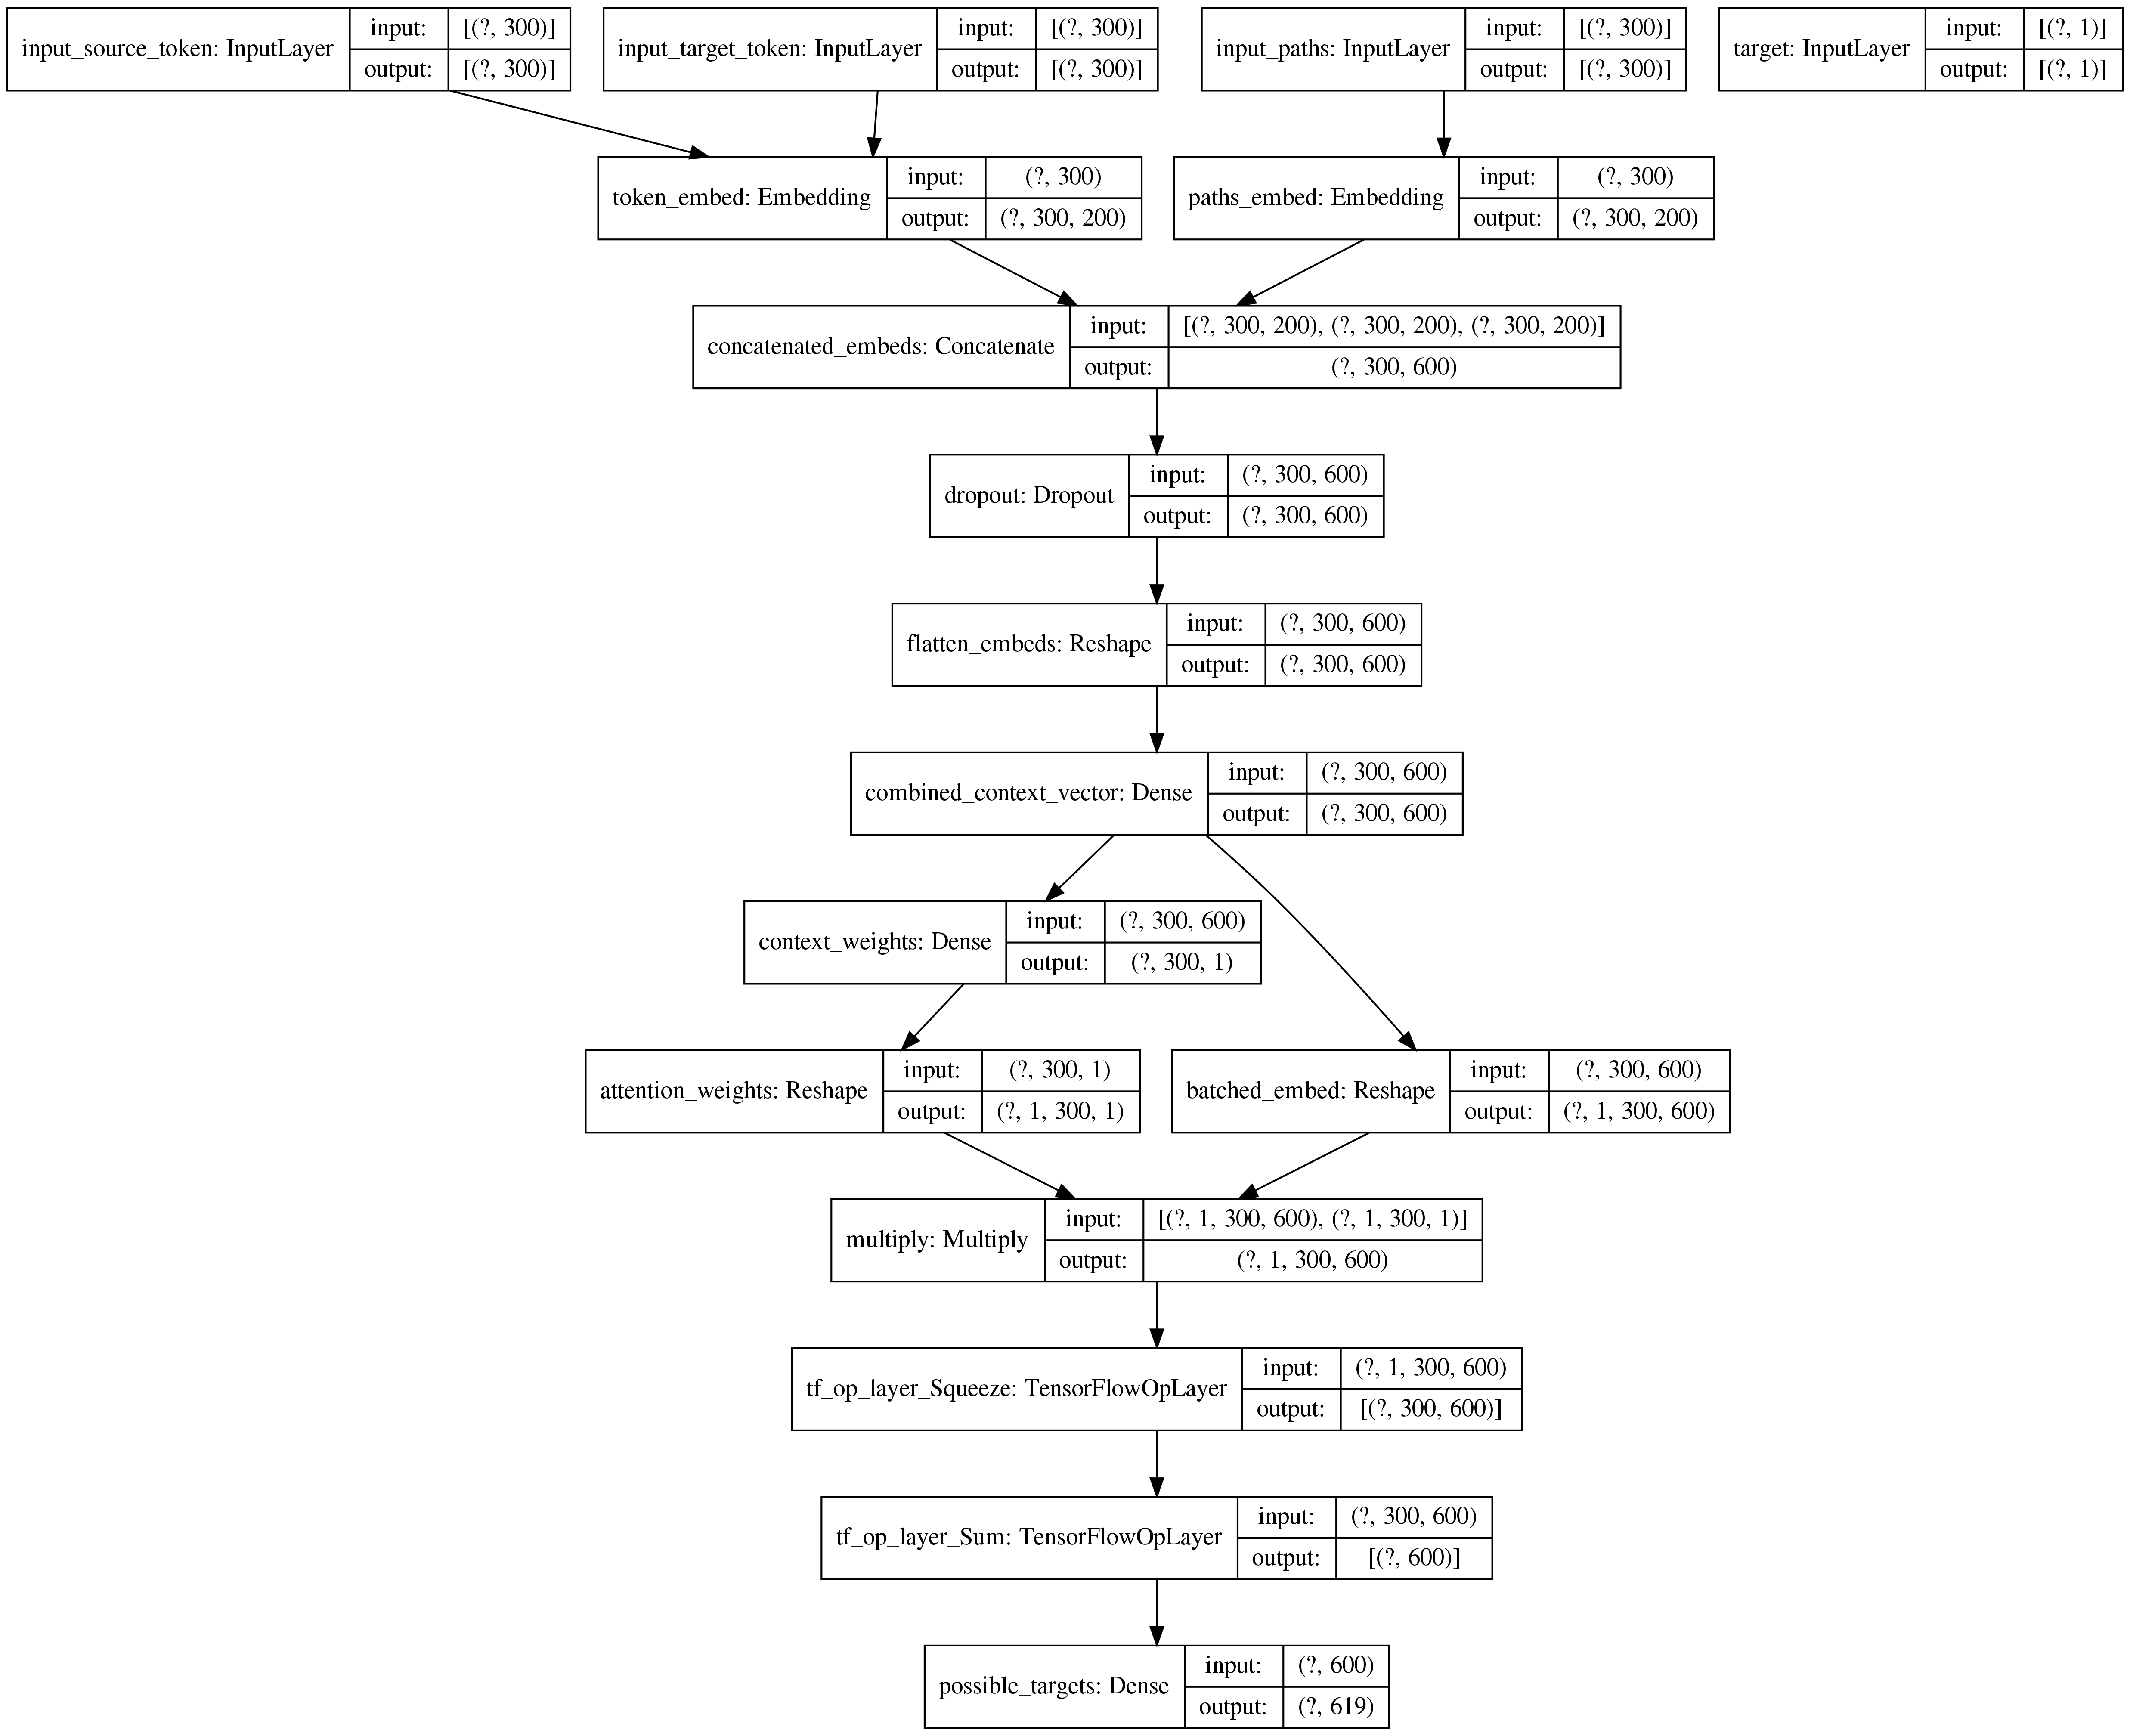

In [10]:
logits = tf.keras.layers.Dot([1, 1],name="logits")([code_vectors, target_embed_model.output])
batch_size = tf.cast(tf.shape(input_target_embed)[0], tf.float32)

inputs = [token_source_embed_model.input, path_embed_model.input, token_target_embed_model.input, target_embed_model.input]
code2vec = tf.keras.Model(inputs=inputs, outputs=possible_targets)
print(code2vec.summary())
tf.keras.utils.plot_model(code2vec, show_shapes=True, dpi=300)

In [11]:
def tf_loss(labels, logits):
    """custom loss function"""
    return tf.keras.backend.sum(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.reshape(labels, [-1]), logits=logits)) / config.config.BATCH_SIZE

In [12]:
code2vec.compile(optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'],  loss="sparse_categorical_crossentropy")


In [13]:
code2vec.fit(dataset, epochs=3)

Epoch 1/3
768/768 [==============================] - 92s 120ms/step - loss: 3.3091 - accuracy: 0.6538
Epoch 2/3
768/768 [==============================] - 92s 120ms/step - loss: 0.3472 - accuracy: 0.9416
Epoch 3/3
768/768 [==============================] - 87s 113ms/step - loss: 0.2813 - accuracy: 0.9504


In [14]:
code2vec.evaluate(dataset)

768/768 [==============================] - 21s 28ms/step - loss: 0.1713 - accuracy: 0.9668


[0.17134258151054382, 0.9667914509773254]

Просто чтобы посмотреть как оно там живёт

In [18]:
for i in range(10):
    it = iter(dataset).get_next()
    for a,b in zip(code2vec(it[0]).numpy().argmax(axis=1), it[1].numpy()):
        print(a, b, a==b)

417 417 True
581 581 True
583 583 True
566 566 True
416 416 True
600 600 True
581 581 True
611 611 True
507 507 True
418 418 True
431 431 True
429 429 True
423 423 True
551 551 True
270 270 True
588 588 True
542 542 True
544 544 True
507 507 True
437 437 True
432 432 True
436 436 True
576 576 True
588 588 True
427 427 True
417 417 True
430 430 True
581 581 True
607 607 True
420 420 True
432 432 True
577 577 True
507 507 True
607 607 True
586 586 True
425 425 True
421 421 True
436 436 True
587 587 True
598 598 True
605 605 True
430 430 True
418 418 True
423 423 True
420 420 True
605 605 True
537 537 True
566 566 True
429 429 True
127 173 False
422 422 True
587 587 True
581 581 True
610 610 True
424 424 True
425 425 True
586 586 True
546 546 True
425 425 True
582 582 True
548 548 True
534 75 False
612 612 True
418 418 True
421 421 True
605 605 True
421 421 True
31 31 True
428 428 True
417 417 True
420 420 True
615 615 True
534 472 False
418 418 True
419 419 True
610 610 True
615 615 True